In [1]:
import pandas as pd
import numpy as np
import pymc as pm
from src.data_utils import load_and_process_data
from src.model import run_full_analysis, build_and_sample_model
from src.trace_save_load import load_previous_season_trace, extract_previous_season_priors, save_season_trace
import matplotlib.pyplot as plt

league = ['Premier_League']
season = '2025-2026'



In [5]:
# Simple one-liner to get everything ready
df, team_mapping, n_teams = load_and_process_data(
    db_path=r'/Users/admin/Documents/dev/algobetting/infra/data/db/fotmob.db',
    league=league, 
    season=season,
    max_goals=9,
    decay_rate=0.002,
    goals_weight=0.18,
    xg_weight=0.45,
    psxg_weight=0.27,
    epv_weight=0.1

)

df.tail()

,match_id,league_id,match_date,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,poisson_binomial_xg_prob,poisson_binomial_psxg_prob,poisson_xg_total_prob,poisson_epv_prob,home_idx,away_idx
2550,4813453,Premier_League,2025-10-19,Tottenham,Aston Villa,3,1,0.007909,1,False,0.009211,0.0,0.010539,0.013556,17,1
2551,4813453,Premier_League,2025-10-19,Tottenham,Aston Villa,3,2,0.001416,1,False,0.001288,0.0,0.001662,0.003440,17,1
2552,4813453,Premier_League,2025-10-19,Tottenham,Aston Villa,4,0,0.004970,1,False,0.003950,0.0,0.007249,0.005701,17,1
2553,4813453,Premier_League,2025-10-19,Tottenham,Aston Villa,4,1,0.001710,1,False,0.001310,0.0,0.002286,0.002894,17,1
2554,4813453,Premier_League,2025-10-19,Tottenham,Aston Villa,5,0,0.000861,1,False,0.000362,0.0,0.001258,0.000974,17,1


In [4]:
goals = df[df['is_actual'] == True]

average_goasl = (goals['home_goals'] + goals['away_goals'])
average_goasl.mean()

np.float64(2.6125)

In [6]:
df[df["match_id"] == 4813453]["weight"].sum()

np.float64(0.9980019986673329)

In [7]:
# manual priors

# Attack strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_att_priors = {
    'Arsenal': (0.198, 0.25),
    'Aston Villa': (0.121, 0.25),
    'Bournemouth': (0.100, 0.25),
    'Brentford': (0.079, 0.25),
    'Brighton': (0.083, 0.25),
    'Chelsea': (0.185, 0.25),
    'Crystal Palace': (0.057, 0.25),
    'Everton': (-0.108, 0.25),
    'Fulham': (-0.030, 0.25),
    'Liverpool': (0.371, 0.25),
    'Man City': (0.297, 0.25),
    'Man United': (0.011, 0.25),
    'Newcastle': (0.207, 0.25),
    'Nottm Forest': (-0.003, 0.25),
    'Tottenham': (0.121, 0.25),
    'West Ham': (-0.082, 0.25),
    'Wolves': (-0.094, 0.25),

    'Burnley': (-0.401, 0.3),
    'Leeds': (-0.103, 0.3),
    'Sunderland': (-0.553, 0.3)
}

# Defense strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_def_priors = {
    'Arsenal': (-0.340, 0.25),
    'Aston Villa': (-0.085, 0.25),
    'Bournemouth': (-0.001, 0.25),
    'Brentford': (-0.054, 0.25),
    'Brighton': (0.107, 0.25),
    'Chelsea': (-0.166, 0.25),
    'Crystal Palace': (0.052, 0.25),
    'Everton': (-0.085, 0.25),
    'Fulham': (-0.014, 0.25),
    'Liverpool': (-0.222, 0.25),
    'Man City': (-0.191, 0.25),
    'Man United': (-0.035, 0.25),
    'Newcastle': (-0.083, 0.25),
    'Nottm Forest': (-0.046, 0.25),
    'Tottenham': (0.163, 0.25),
    'West Ham': (0.103, 0.25),
    'Wolves': (0.137, 0.25),

    'Burnley': (0.163, 0.3),
    'Leeds': (0.163, 0.3),
    'Sunderland': (0.231, 0.3)
}



In [8]:
model, trace = build_and_sample_model(
     df, 
     n_teams, 
     team_mapping=team_mapping,
     trace=20000,
     tune=10000,
     manual_att_priors=manual_att_priors,
     manual_def_priors=manual_def_priors
 )

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
att_str_raw[0]   0.257  0.198  -0.108    0.627      0.003    0.003    6216.0    3217.0    1.0
att_str_raw[1]  -0.019  0.210  -0.399    0.383      0.002    0.004    7188.0    3038.0    1.0
att_str_raw[2]   0.116  0.199  -0.257    0.486      0.002    0.003    6943.0    3090.0    1.0
att_str_raw[3]   0.099  0.198  -0.253    0.485      0.003    0.004    5828.0    2360.0    1.0
att_str_raw[4]   0.131  0.202  -0.236    0.513      0.002    0.004    7350.0    3244.0    1.0
att_str_raw[5]  -0.356  0.237  -0.819    0.083      0.003    0.004    6970.0    3131.0    1.0
att_str_raw[6]   0.283  0.194  -0.077    0.649      0.002    0.003    6727.0    3167.0    1.0
att_str_raw[7]   0.203  0.197  -0.152    0.572      0.002    0.003    6343.0    3006.0    1.0
att_str_raw[8]  -0.093  0.202  -0.470    0.276      0.002    0.003    7249.0    3481.0    1.0
att_str_raw[9]  -0.056  0.205  -0.435    0.338      0.002   

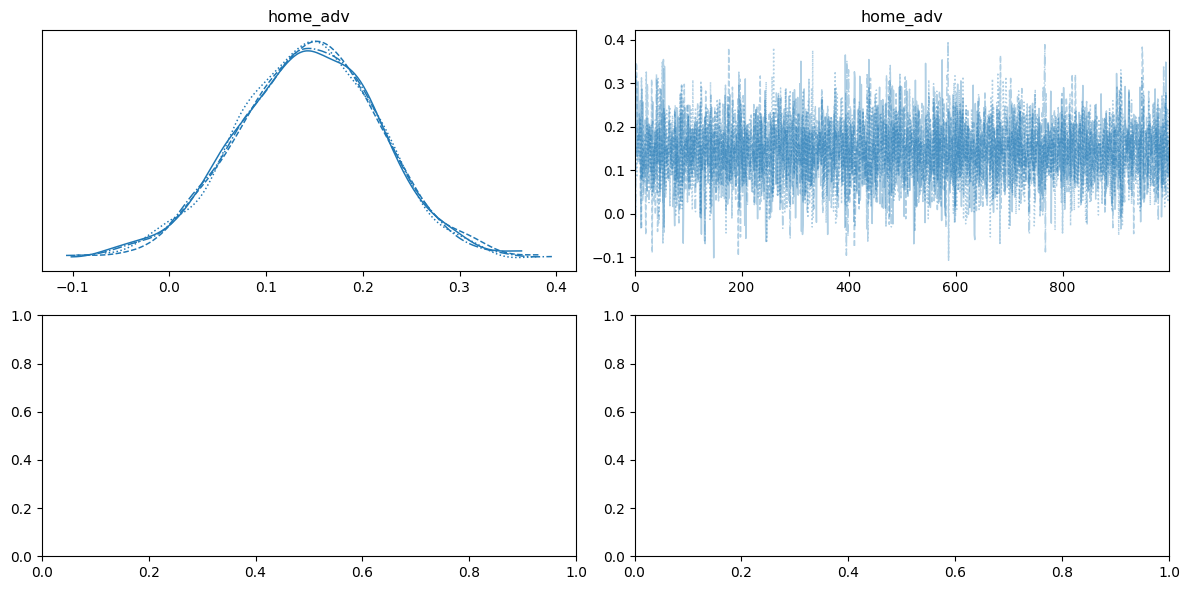

In [9]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

# Quick summary - full table display with 2 decimal places
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)  # Prevents wrapping
pd.set_option('display.precision', 3)  # 2 decimal places

summary = az.summary(trace)
print(summary)

# Quick plots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Trace plots for key parameters
az.plot_trace(trace, var_names=['home_adv'], axes=axes)
plt.tight_layout()
plt.show()


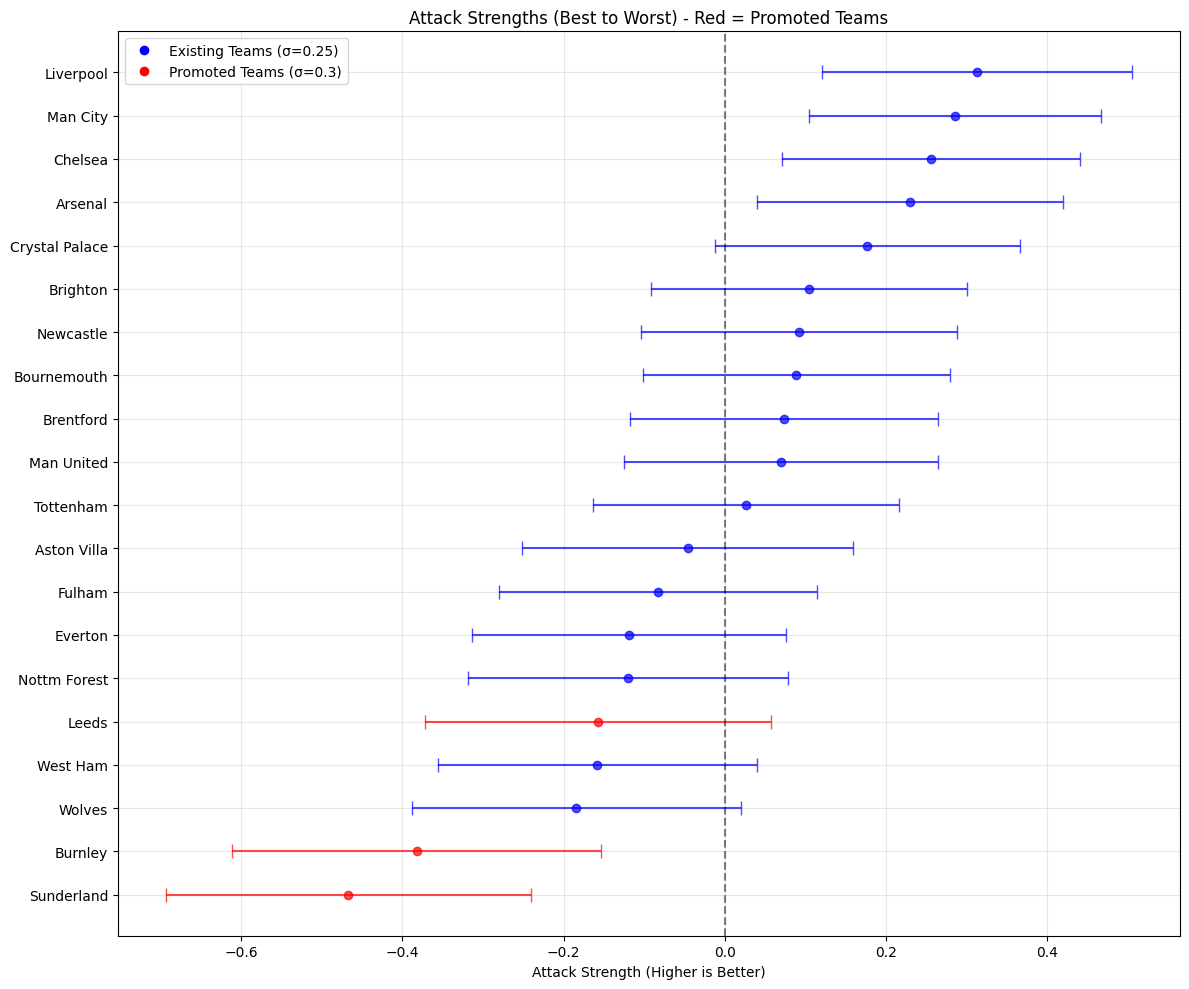

In [11]:
# Extract attack data
att_means = []
att_stds = []
att_team_names = []

for i in range(20):
    team_name = [k for k, v in team_mapping.items() if v == i][0]
    att_means.append(summary.loc[f'att_str[{i}]', 'mean'])
    att_stds.append(summary.loc[f'att_str[{i}]', 'sd'])
    att_team_names.append(team_name)

# Create DataFrame and sort by attack strength (higher is better attack)
att_data = list(zip(att_means, att_stds, att_team_names))
att_data_sorted = sorted(att_data, key=lambda x: x[0], reverse=True)  # Sort by mean (descending)

# Extract sorted data
sorted_att_means = [x[0] for x in att_data_sorted]
sorted_att_stds = [x[1] for x in att_data_sorted]
sorted_att_names = [x[2] for x in att_data_sorted]

# Create attack plot (best to worst)
fig, ax = plt.subplots(figsize=(12, 10))

promoted_teams = ['Burnley', 'Leeds', 'Sunderland']

for i, (mean, std, name) in enumerate(zip(sorted_att_means, sorted_att_stds, sorted_att_names)):
    color = 'red' if name in promoted_teams else 'blue'
    # Flip the y-position so best is at top
    ax.errorbar(mean, len(sorted_att_names)-1-i, xerr=std, fmt='o', capsize=5, 
                color=color, ecolor=color, alpha=0.7)

ax.set_yticks(range(len(sorted_att_names)))
ax.set_yticklabels(reversed(sorted_att_names))  # Reverse the labels to match
ax.set_xlabel('Attack Strength (Higher is Better)')
ax.set_title('Attack Strengths (Best to Worst) - Red = Promoted Teams')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                         markersize=8, label='Existing Teams (σ=0.25)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Promoted Teams (σ=0.3)')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

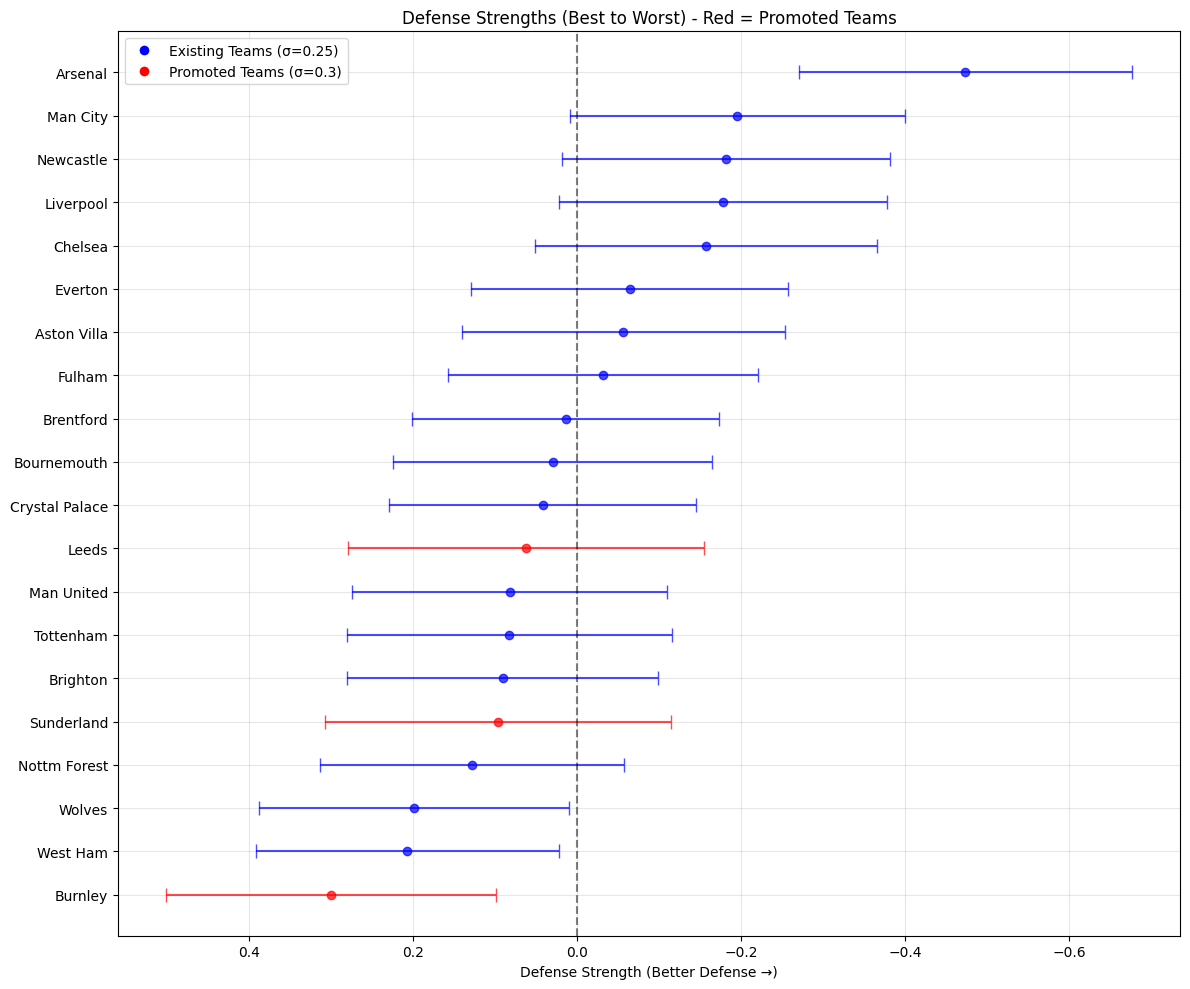

In [12]:
# Extract defense data
def_means = []
def_stds = []
def_team_names = []

for i in range(20):
    team_name = [k for k, v in team_mapping.items() if v == i][0]
    def_means.append(summary.loc[f'def_str[{i}]', 'mean'])
    def_stds.append(summary.loc[f'def_str[{i}]', 'sd'])
    def_team_names.append(team_name)

# Create DataFrame and sort by defense strength (lower is better defense)
def_data = list(zip(def_means, def_stds, def_team_names))
def_data_sorted = sorted(def_data, key=lambda x: x[0])  # Sort by mean (ascending)

# Extract sorted data
sorted_def_means = [x[0] for x in def_data_sorted]
sorted_def_stds = [x[1] for x in def_data_sorted]
sorted_def_names = [x[2] for x in def_data_sorted]

# Create defense plot (best to worst)
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(sorted_def_names))

promoted_teams = ['Burnley', 'Leeds', 'Sunderland']

for i, (mean, std, name) in enumerate(zip(sorted_def_means, sorted_def_stds, sorted_def_names)):
    color = 'red' if name in promoted_teams else 'blue'
    # Reverse y-position so best defense is at top
    ax.errorbar(mean, len(sorted_def_names)-1-i, xerr=std, fmt='o', capsize=5, 
                color=color, ecolor=color, alpha=0.7)

ax.set_yticks(range(len(sorted_def_names)))
ax.set_yticklabels(reversed(sorted_def_names))  # Reverse labels to match reversed positions
ax.set_xlabel('Defense Strength (Better Defense →)')
ax.set_title('Defense Strengths (Best to Worst) - Red = Promoted Teams')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.invert_xaxis()  # Flip x-axis so negative is to the right

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                         markersize=8, label='Existing Teams (σ=0.25)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Promoted Teams (σ=0.3)')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

In [13]:
# Team ratings vs average team (0 rating)
import numpy as np

# Get baseline and home advantage from trace
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

print("=== TEAM RATINGS VS AVERAGE TEAM ===")
print(f"Baseline (neutral venue): {baseline_mean:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")
print()

# Calculate goals for/against vs average team (0,0 ratings)
team_ratings = []

for team, idx in team_mapping.items():
    att_strength = summary.loc[f'att_str[{idx}]', 'mean']
    def_strength = summary.loc[f'def_str[{idx}]', 'mean']
    
    # Goals scored vs average team at home
    goals_for = np.exp(baseline_mean + att_strength + 0 )  # vs avg def (0)

    
    # Goals conceded vs average team away
    goals_against = np.exp(baseline_mean + 0 + def_strength)  # avg att (0) with home adv
    
    goal_difference = goals_for - goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': goals_for,
        'goals_against': goals_against,
        'goal_diff_vs_avg': goal_difference,
    })

# Convert to DataFrame and sort by goal difference
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff_vs_avg', ascending=False)

print(f'Total Goals For: {ratings_df['goals_for'].sum():.2f}')
print(f'Total Goals Against: {ratings_df['goals_against'].sum():.2f}')
print()

# Display main table
print("TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):")
print("=" * 80)
display_df = ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff_vs_avg']].copy()

pd.set_option('display.float_format', '{:.2f}'.format)
print(display_df.to_string(index=False))

=== TEAM RATINGS VS AVERAGE TEAM ===
Baseline (neutral venue): 0.225
Home advantage: 0.144

Total Goals For: 25.57
Total Goals Against: 25.40

TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):
          team  goals_for  goals_against  goal_diff_vs_avg
       Arsenal       1.58           0.78              0.80
     Liverpool       1.71           1.05              0.66
      Man City       1.67           1.03              0.64
       Chelsea       1.62           1.07              0.55
     Newcastle       1.37           1.04              0.33
Crystal Palace       1.49           1.31              0.19
   Bournemouth       1.37           1.29              0.08
     Brentford       1.35           1.27              0.08
      Brighton       1.39           1.37              0.02
   Aston Villa       1.20           1.18              0.01
    Man United       1.34           1.36             -0.02
        Fulham       1.15           1.21             -0.06
       Everton       1.11       

In [14]:
# Team ratings vs average team (0 rating)
import numpy as np

# Get baseline and home advantage from trace
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

print("=== TEAM RATINGS VS AVERAGE TEAM ===")
print(f"Baseline (neutral venue): {baseline_mean:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")
print()

# Calculate goals for/against vs average team (0,0 ratings)
team_ratings = []
for team, idx in team_mapping.items():
    att_strength = summary.loc[f'att_str[{idx}]', 'mean']
    def_strength = summary.loc[f'def_str[{idx}]', 'mean']
    
    # Goals scored vs average team AT HOME
    goals_for_home = np.exp(baseline_mean + home_adv_mean + att_strength + 0)  # vs avg def (0)
    
    # Goals scored vs average team AWAY
    goals_for_away = np.exp(baseline_mean + att_strength + 0)  # vs avg def (0), no home adv
    
    # Average goals for
    goals_for = (goals_for_home + goals_for_away) / 2
    
    # Goals conceded vs average team AT HOME (defending)
    goals_against_home = np.exp(baseline_mean + 0 + def_strength)  # avg att (0), no home adv for opponent
    
    # Goals conceded vs average team AWAY (defending)
    goals_against_away = np.exp(baseline_mean + home_adv_mean + 0 + def_strength)  # avg att (0) with opponent's home adv
    
    # Average goals against
    goals_against = (goals_against_home + goals_against_away) / 2
    
    goal_difference = goals_for - goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': goals_for,
        'goals_against': goals_against,
        'goal_diff_vs_avg': goal_difference,
    })

# Convert to DataFrame and sort by goal difference
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff_vs_avg', ascending=False)

print(f'Total Goals For: {ratings_df["goals_for"].sum():.2f}')
print(f'Total Goals Against: {ratings_df["goals_against"].sum():.2f}')
print()

# Display main table
print("TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):")
print("=" * 80)
display_df = ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff_vs_avg']].copy()
pd.set_option('display.float_format', '{:.2f}'.format)
print(display_df.to_string(index=False))

=== TEAM RATINGS VS AVERAGE TEAM ===
Baseline (neutral venue): 0.225
Home advantage: 0.144

Total Goals For: 27.55
Total Goals Against: 27.37

TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):
          team  goals_for  goals_against  goal_diff_vs_avg
       Arsenal       1.70           0.84              0.86
     Liverpool       1.85           1.13              0.72
      Man City       1.80           1.11              0.69
       Chelsea       1.74           1.15              0.59
     Newcastle       1.48           1.13              0.35
Crystal Palace       1.61           1.41              0.20
   Bournemouth       1.47           1.39              0.08
     Brentford       1.45           1.37              0.08
      Brighton       1.50           1.48              0.02
   Aston Villa       1.29           1.28              0.01
    Man United       1.45           1.46             -0.02
        Fulham       1.24           1.31             -0.07
       Everton       1.20       

In [15]:
# Convert team_mapping dict to list of team names in index order
team_names = [None] * len(team_mapping)
for team, idx in team_mapping.items():
    team_names[idx] = team

# Save the trace with team names
trace_path = save_season_trace(
    trace=trace,
    season_year=2025.7,  # Replace with your actual season year
    league="Premier_League",       # Replace with your league code (e.g., "PL", "La Liga", etc.)
    team_names=team_names,
    model_version="manual_priors"
)

print(f"Trace saved to: {trace_path}")

Saved trace for 2025.7
Trace saved to: model_traces/manual_priors/trace_Premier_League_2025.7.nc


In [27]:
import numpy as np
import pandas as pd

def predict_match(home_team, away_team, trace, team_mapping):
    """
    Predict goals for a match between two teams
    
    Parameters:
    home_team: str - name of home team
    away_team: str - name of away team  
    trace: pymc trace object
    team_mapping: dict - maps team names to indices
    
    Returns:
    dict with predictions
    """
    
    # Get team indices
    home_idx = team_mapping[home_team]
    away_idx = team_mapping[away_team]
    
    # Extract posterior samples
    att_str = trace.posterior['att_str'].values.reshape(-1, len(team_mapping))
    def_str = trace.posterior['def_str'].values.reshape(-1, len(team_mapping))
    baseline = trace.posterior['baseline'].values.flatten()
    home_adv = trace.posterior['home_adv'].values.flatten()
    
    # Calculate expected goals for each posterior sample
    home_goals_lambda = np.exp(
        baseline + 
        att_str[:, home_idx] + 
        def_str[:, away_idx] + 
        home_adv
    )
    
    away_goals_lambda = np.exp(
        baseline + 
        att_str[:, away_idx] + 
        def_str[:, home_idx]
    )
    
    # Generate actual goal predictions using Poisson
    home_goals_pred = np.random.poisson(home_goals_lambda)
    away_goals_pred = np.random.poisson(away_goals_lambda)
    
    return {
        'home_team': home_team,
        'away_team': away_team,
        'home_goals_expected': np.mean(home_goals_lambda),
        'away_goals_expected': np.mean(away_goals_lambda),
        'home_goals_median': np.median(home_goals_pred),
        'away_goals_median': np.median(away_goals_pred),
        'home_win_prob': np.mean(home_goals_pred > away_goals_pred),
        'draw_prob': np.mean(home_goals_pred == away_goals_pred), 
        'away_win_prob': np.mean(home_goals_pred < away_goals_pred)
    }

# Predict multiple matches
matches = [
    ('Arsenal', 'Crystal Palace'),
    ('Aston Villa', 'Man City'),
    ('Bournemouth', 'Nottm Forest'),
    ('Brentford', 'Liverpool'),
    ('Chelsea', 'Sunderland'),
    ('Everton', 'Tottenham'),
    ('Leeds', 'West Ham'),
    ('Man United', 'Brighton'),
    ('Newcastle', 'Fulham'),
    ('Wolves', 'Burnley')
]

print("\n" + "="*60)
print("MATCH PREDICTIONS")
print("="*60)

total_goals = 0
for home, away in matches:
    result = predict_match(home, away, trace, team_mapping)
    match_total = result['home_goals_expected'] + result['away_goals_expected']
    total_goals += match_total
    print(f"{home:15} vs {away:15}: {result['home_goals_expected']:.2f}-{result['away_goals_expected']:.2f} "
          f"({result['home_win_prob']:.0%}-{result['draw_prob']:.0%}-{result['away_win_prob']:.0%}) "
          f"Total: {match_total:.1f}")

print("="*60)
print(f"TOTAL GOALS ACROSS ALL MATCHES: {total_goals:.2f}")
print(f"AVERAGE GOALS PER MATCH: {total_goals/len(matches):.2f}")


MATCH PREDICTIONS
Arsenal         vs Crystal Palace : 1.97-0.97 (61%-19%-20%) Total: 2.9
Aston Villa     vs Man City       : 1.19-1.64 (30%-24%-47%) Total: 2.8
Bournemouth     vs Nottm Forest   : 1.87-1.19 (52%-22%-25%) Total: 3.1
Brentford       vs Liverpool      : 1.36-1.81 (30%-21%-49%) Total: 3.2
Chelsea         vs Sunderland     : 2.14-0.71 (70%-19%-11%) Total: 2.9
Everton         vs Tottenham      : 1.45-1.26 (41%-26%-32%) Total: 2.7
Leeds           vs West Ham       : 1.59-1.19 (45%-24%-31%) Total: 2.8
Man United      vs Brighton       : 1.77-1.57 (44%-21%-35%) Total: 3.3
Newcastle       vs Fulham         : 1.60-1.00 (50%-25%-24%) Total: 2.6
Wolves          vs Burnley        : 1.70-1.09 (50%-24%-26%) Total: 2.8
TOTAL GOALS ACROSS ALL MATCHES: 29.06
AVERAGE GOALS PER MATCH: 2.91


In [24]:
def print_league_table(league_table):
    """Print formatted league table with xG stats"""
    
    # Convert to DataFrame for easier sorting
    df = pd.DataFrame.from_dict(league_table, orient='index')
    df = df.sort_values(['points', 'goal_difference', 'goals_for'], ascending=[False, False, False])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'team'}, inplace=True)
    df.index = df.index + 1  # Start position from 1
    
    print("\n" + "="*110)
    print("PREDICTED FINAL LEAGUE TABLE (with Expected Goals)")
    print("="*110)
    print(f"{'Pos':>3} {'Team':15} {'P':>2} {'W':>2} {'D':>2} {'L':>2} {'GF':>3} {'GA':>3} {'GD':>4} {'xGF':>5} {'xGA':>5} {'xGD':>5} {'Pts':>3}")
    print("-"*110)
    
    for pos, row in df.iterrows():
        print(f"{pos:>3} {row['team']:15} {row['played']:>2} {row['wins']:>2} "
              f"{row['draws']:>2} {row['losses']:>2} {row['goals_for']:>3} "
              f"{row['goals_against']:>3} {row['goal_difference']:>+4} "
              f"{row['xg_for']:>5.1f} {row['xg_against']:>5.1f} {row['xg_difference']:>+5.1f} {row['points']:>3}")
    
    return df

def simulate_full_season(trace, team_mapping, df_actual):
    """Simulate a full season using actual results where available and simulating unplayed matches"""
    
    teams = list(team_mapping.keys())
    
    # Initialize league table with xG stats
    league_table = {team: {
        'played': 0,
        'wins': 0,
        'draws': 0,
        'losses': 0,
        'goals_for': 0,
        'goals_against': 0,
        'goal_difference': 0,
        'xg_for': 0.0,
        'xg_against': 0.0,
        'xg_difference': 0.0,
        'points': 0
    } for team in teams}
    
    all_matches = []
    
    # Create a set of played matches for quick lookup
    # Assuming df_actual has columns: home_team, away_team, is_actual
    played_matches = set()
    if df_actual is not None and 'is_actual' in df_actual.columns:
        actual_games = df_actual[df_actual['is_actual'] == True]
        for _, row in actual_games.iterrows():
            played_matches.add((row['home_team'], row['away_team']))
    
    # Generate all possible matches
    for home_team in teams:
        for away_team in teams:
            if home_team != away_team:
                
                # Check if this match has already been played
                if (home_team, away_team) in played_matches:
                    # Use actual result
                    actual_match = df_actual[
                        (df_actual['home_team'] == home_team) & 
                        (df_actual['away_team'] == away_team) & 
                        (df_actual['is_actual'] == True)
                    ].iloc[0]
                    
                    home_goals = int(actual_match['home_goals'])
                    away_goals = int(actual_match['away_goals'])
                    
                    # Get xG if available in the dataframe, otherwise predict
                    if 'home_xg' in actual_match and 'away_xg' in actual_match:
                        home_xg = actual_match['home_xg']
                        away_xg = actual_match['away_xg']
                    else:
                        result = predict_match(home_team, away_team, trace, team_mapping)
                        home_xg = result['home_goals_expected']
                        away_xg = result['away_goals_expected']
                    
                    match_result = {
                        'home_team': home_team,
                        'away_team': away_team,
                        'home_goals': home_goals,
                        'away_goals': away_goals,
                        'home_expected': home_xg,
                        'away_expected': away_xg,
                        'is_actual': True
                    }
                else:
                    # Simulate the match
                    result = predict_match(home_team, away_team, trace, team_mapping)
                    
                    home_goals = np.random.poisson(result['home_goals_expected'])
                    away_goals = np.random.poisson(result['away_goals_expected'])
                    
                    match_result = {
                        'home_team': home_team,
                        'away_team': away_team,
                        'home_goals': home_goals,
                        'away_goals': away_goals,
                        'home_expected': result['home_goals_expected'],
                        'away_expected': result['away_goals_expected'],
                        'is_actual': False
                    }
                
                all_matches.append(match_result)
                
                # Update league table for home team
                league_table[home_team]['played'] += 1
                league_table[home_team]['goals_for'] += home_goals
                league_table[home_team]['goals_against'] += away_goals
                league_table[home_team]['xg_for'] += match_result['home_expected']
                league_table[home_team]['xg_against'] += match_result['away_expected']
                
                if home_goals > away_goals:
                    league_table[home_team]['wins'] += 1
                    league_table[home_team]['points'] += 3
                elif home_goals == away_goals:
                    league_table[home_team]['draws'] += 1
                    league_table[home_team]['points'] += 1
                else:
                    league_table[home_team]['losses'] += 1
                
                # Update league table for away team
                league_table[away_team]['played'] += 1
                league_table[away_team]['goals_for'] += away_goals
                league_table[away_team]['goals_against'] += home_goals
                league_table[away_team]['xg_for'] += match_result['away_expected']
                league_table[away_team]['xg_against'] += match_result['home_expected']
                
                if away_goals > home_goals:
                    league_table[away_team]['wins'] += 1
                    league_table[away_team]['points'] += 3
                elif away_goals == home_goals:
                    league_table[away_team]['draws'] += 1
                    league_table[away_team]['points'] += 1
                else:
                    league_table[away_team]['losses'] += 1
    
    # Calculate differences
    for team in teams:
        league_table[team]['goal_difference'] = (
            league_table[team]['goals_for'] - league_table[team]['goals_against']
        )
        league_table[team]['xg_difference'] = (
            league_table[team]['xg_for'] - league_table[team]['xg_against']
        )
    
    return league_table, all_matches

# Usage:
print("Simulating full season with actual results...")
league_table, all_matches = simulate_full_season(trace, team_mapping, df)  # Pass your df here
final_table = print_league_table(league_table)

# Additional statistics showing actual vs simulated
actual_matches = sum(1 for match in all_matches if match.get('is_actual', False))
simulated_matches = len(all_matches) - actual_matches
total_goals = sum([match['home_goals'] + match['away_goals'] for match in all_matches])

print(f"\nSEASON STATISTICS:")
print(f"Actual matches: {actual_matches}")
print(f"Simulated matches: {simulated_matches}")
print(f"Total matches: {len(all_matches)}")
print(f"Total goals: {total_goals}")
print(f"Average goals per match: {total_goals/len(all_matches):.2f}")


Simulating full season with actual results...

PREDICTED FINAL LEAGUE TABLE (with Expected Goals)
Pos Team             P  W  D  L  GF  GA   GD   xGF   xGA   xGD Pts
--------------------------------------------------------------------------------------------------------------
  1 Arsenal         38 29  6  3  88  29  +59  69.4  33.6 +35.8  93
  2 Chelsea         38 24  6  8  81  39  +42  70.4  46.1 +24.3  78
  3 Liverpool       38 22  5 11  72  44  +28  74.7  44.8 +29.9  71
  4 Man City        38 20 10  8  70  43  +27  72.5  44.2 +28.3  70
  5 Newcastle       38 19 12  7  52  32  +20  59.9  45.3 +14.5  69
  6 Aston Villa     38 17 10 11  56  44  +12  52.0  51.7  +0.2  61
  7 Brentford       38 17  5 16  59  53   +6  58.1  55.0  +3.1  56
  8 Man United      38 16  8 14  51  48   +3  57.9  58.9  -1.0  56
  9 Crystal Palace  38 14 13 11  64  47  +17  64.4  56.2  +8.2  55
 10 Tottenham       38 15 10 13  53  55   -2  55.3  59.2  -3.9  55
 11 Brighton        38 15  7 16  58  64   -6  59.9  59

In [25]:
import numpy as np
import pandas as pd
from collections import defaultdict

def run_multiple_seasons(n_simulations, trace, team_mapping, df_actual):
    """Run multiple season simulations using actual results and return averaged results"""
    
    teams = list(team_mapping.keys())
    
    # Initialize accumulated statistics - now including xG
    accumulated_stats = {team: {
        'total_points': 0,
        'total_wins': 0,
        'total_draws': 0, 
        'total_losses': 0,
        'total_goals_for': 0,
        'total_goals_against': 0,
        'total_xg_for': 0.0,
        'total_xg_against': 0.0,
        'position_sum': 0
    } for team in teams}
    
    # Track position frequencies
    position_counts = {team: [0] * 20 for team in teams}  # 20 positions
    
    print(f"Running {n_simulations} season simulations...")
    
    for sim in range(n_simulations):
        if (sim + 1) % 1000 == 0:
            print(f"Completed {sim + 1} simulations...")
        
        # Run single season simulation with actual results
        league_table, _ = simulate_full_season(trace, team_mapping, df_actual)
        
        # Convert to DataFrame and sort
        df = pd.DataFrame.from_dict(league_table, orient='index')
        df = df.sort_values(['points', 'goal_difference', 'goals_for'], 
                           ascending=[False, False, False])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'team'}, inplace=True)
        
        # Accumulate statistics
        for pos, row in df.iterrows():
            team = row['team']
            final_position = pos + 1  # Position 1-20
            
            accumulated_stats[team]['total_points'] += row['points']
            accumulated_stats[team]['total_wins'] += row['wins']
            accumulated_stats[team]['total_draws'] += row['draws']
            accumulated_stats[team]['total_losses'] += row['losses']
            accumulated_stats[team]['total_goals_for'] += row['goals_for']
            accumulated_stats[team]['total_goals_against'] += row['goals_against']
            accumulated_stats[team]['total_xg_for'] += row['xg_for']
            accumulated_stats[team]['total_xg_against'] += row['xg_against']
            accumulated_stats[team]['position_sum'] += final_position
            
            # Track position frequency
            position_counts[team][pos] += 1
    
    # Calculate averages
    avg_results = []
    for team in teams:
        stats = accumulated_stats[team]
        avg_results.append({
            'team': team,
            'avg_points': stats['total_points'] / n_simulations,
            'avg_wins': stats['total_wins'] / n_simulations,
            'avg_draws': stats['total_draws'] / n_simulations,
            'avg_losses': stats['total_losses'] / n_simulations,
            'avg_goals_for': stats['total_goals_for'] / n_simulations,
            'avg_goals_against': stats['total_goals_against'] / n_simulations,
            'avg_xg_for': stats['total_xg_for'] / n_simulations,
            'avg_xg_against': stats['total_xg_against'] / n_simulations,
            'avg_position': stats['position_sum'] / n_simulations
        })
    
    # Create DataFrame and sort by average points
    avg_df = pd.DataFrame(avg_results)
    avg_df['avg_goal_difference'] = avg_df['avg_goals_for'] - avg_df['avg_goals_against']
    avg_df['avg_xg_difference'] = avg_df['avg_xg_for'] - avg_df['avg_xg_against']
    avg_df = avg_df.sort_values(['avg_points', 'avg_goal_difference', 'avg_goals_for'], 
                               ascending=[False, False, False])
    avg_df.reset_index(drop=True, inplace=True)
    avg_df.index = avg_df.index + 1
    
    return avg_df, position_counts

# Run simulations with actual results
n_sims = 1000
print(f"Using actual results and simulating remaining fixtures...")
avg_table, position_freq = run_multiple_seasons(n_sims, trace, team_mapping, df)

# Count actual matches to calculate correct games per season
actual_matches_per_team = df[df['is_actual'] == True].groupby('home_team').size().mean() + \
                           df[df['is_actual'] == True].groupby('away_team').size().mean()
games_per_season = 38  # Total games in a full season

# Print averaged league table with per-game stats
print("\n" + "="*150)
print(f"AVERAGE LEAGUE TABLE OVER {n_sims:,} SIMULATIONS (Per Game Stats)")
print("="*150)
print(f"{'Pos':>3} {'Team':15} {'Pts':>5} {'W':>5} {'D':>5} {'L':>5} {'GF/G':>6} {'GA/G':>6} {'GD/G':>6} {'xGF/G':>7} {'xGA/G':>7} {'xGD/G':>7} {'Avg Pos':>8}")
print("-"*150)

for pos, row in avg_table.iterrows():
    print(f"{pos:>3} {row['team']:15} {row['avg_points']:5.1f} {row['avg_wins']:5.1f} "
          f"{row['avg_draws']:5.1f} {row['avg_losses']:5.1f} "
          f"{row['avg_goals_for']/games_per_season:6.2f} "
          f"{row['avg_goals_against']/games_per_season:6.2f} "
          f"{row['avg_goal_difference']/games_per_season:>+6.2f} "
          f"{row['avg_xg_for']/games_per_season:7.2f} "
          f"{row['avg_xg_against']/games_per_season:7.2f} "
          f"{row['avg_xg_difference']/games_per_season:>+7.2f} "
          f"{row['avg_position']:8.2f}")

# Additional info about the simulation
print("\n" + "="*150)
print("SIMULATION INFO:")
actual_match_count = df[df['is_actual'] == True].shape[0]
total_season_matches = len(teams) * (len(teams) - 1)  # Each team plays every other team twice
simulated_match_count = total_season_matches - actual_match_count
print(f"Actual matches used: {actual_match_count}")
print(f"Matches simulated per iteration: {simulated_match_count}")
print(f"Total simulated matches across all simulations: {simulated_match_count * n_sims:,}")
print("="*150)

Using actual results and simulating remaining fixtures...
Running 1000 season simulations...
Completed 1000 simulations...

AVERAGE LEAGUE TABLE OVER 1,000 SIMULATIONS (Per Game Stats)
Pos Team              Pts     W     D     L   GF/G   GA/G   GD/G   xGF/G   xGA/G   xGD/G  Avg Pos
------------------------------------------------------------------------------------------------------------------------------------------------------
  1 Arsenal          79.2  23.8   7.7   6.5   1.85   0.78  +1.07    1.83    0.88   +0.94     1.64
  2 Liverpool        72.5  22.1   6.3   9.6   1.96   1.20  +0.76    1.97    1.18   +0.79     3.00
  3 Man City         71.3  21.3   7.5   9.2   1.95   1.08  +0.87    1.91    1.16   +0.74     3.16
  4 Chelsea          67.6  19.7   8.6   9.7   1.88   1.19  +0.69    1.85    1.21   +0.64     4.17
  5 Newcastle        58.3  16.1  10.2  11.8   1.43   1.12  +0.32    1.58    1.19   +0.38     7.59
  6 Bournemouth      58.3  16.1   9.9  12.0   1.60   1.45  +0.15    1.55    

NameError: name 'teams' is not defined